# Highway Scene Segmentation

The goal of this work is to implement a model for semantic scene segmentation that separates the background from moving cars in the foreground. To achieve this, we will use frames from the highway scene in the Change Detection dataset, which consists of labeled recordings from a highway camera.

http://jacarini.dinf.usherbrooke.ca/dataset2014#

(The first 470 images are unlabeled and will be ignored.)

![input image](showcase/in001600.jpg "Title") ![gt image](showcase/gt001600.png "Title")

## Imports

In [34]:
import os
#import pandas as pd
from torch.utils.data import Dataset, random_split
from torchvision.io import read_image
from torchvision import transforms
import torchvision.transforms.functional as TF

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score

import numpy as np
from sklearn.model_selection import train_test_split

import cv2 as cv
import matplotlib.pyplot as plt
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Pytorch Dataset Wrapper
Inherits from **torch.utils.data.Dataset** and implements two methods.
- **def \_\_getitem\_\_(self, idx)**: given an integer idx returns the data x,y
    - x is the image as a float tensor of shape: $(3,H,W)$
    - y is the label image as a mask of shape: $(H,W)$ each pixel should contain the label 0 (background) or 1 (foreground). It is recommended to use the type torch.long

Image resolution is decreased to fit at once into memory and GPU. Some regularization through color jittering.

In [35]:
class HighwayDataset(Dataset):
    def __init__(self, device, transform=None, target_transform=None):
        self.input_filenames = sorted(os.listdir("highway/input"))[470:]
        self.gts_filenames = sorted(os.listdir("highway/groundtruth"))[470:]

        self.device = device

        self.inputs = []
        self.gts = []

        resize = transforms.Resize((60, 80)) # 30,40
        jit = transforms.ColorJitter(0.2,0.2,0.2,0.05)
        for i in range(len(self.input_filenames)):
            image = read_image( "highway/input/" + self.input_filenames[i] ).float()#.to(device)
            label = read_image( "highway/groundtruth/" + self.gts_filenames[i] )#.float()#.to(device)

            for j in range(10):

                image_aug = jit(resize(image)/255)
                label_aug = (resize(label)[0] > 0).long()

                self.inputs.append(image_aug.detach())
                self.gts.append(label_aug.detach())

        self.inputs = torch.stack(self.inputs).to(device)
        self.gts = torch.stack(self.gts).to(device)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.gts[idx]

In [36]:
highwayDataset = HighwayDataset(device)
highwayDataset.inputs.shape

torch.Size([12300, 3, 60, 80])

## Fully-Convolutional Neural Network
The CNN inspired by U-Net is flexible to the input and output resolution and includes residual blocks.

- input: a batch of images $(B,3,H,W)$
- output: a batch of pixel-wise class predictions $(B,C,H,W)$, where $C=2$

In [37]:
class SegmenterNet(nn.Module):
    def __init__(self):
        super(SegmenterNet, self).__init__()

        self.sideconv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.sideconv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.sideconv3 = nn.Conv2d(64, 64, 3, 1, 1)
        self.lower_upconv = nn.ConvTranspose2d(64, 64, 2, 2)
        self.sideconv4 = nn.Conv2d(64, 32, 3, 1, 1)
        self.higher_upconv = nn.ConvTranspose2d(32, 32, 2, 2)
        self.sideconv5 = nn.Conv2d(32, 2, 3, 1, 1)

    def forward(self, x):

        higher_residual = self.sideconv1(x)
        x = F.relu(higher_residual)

        x = F.max_pool2d(x, 2)

        lower_residual = self.sideconv2(x)
        x = F.relu(lower_residual)

        x = F.max_pool2d(x, 2)

        x = self.sideconv3(x)
        x = F.relu(x)

        x = self.lower_upconv(x) + lower_residual
        x = F.relu(x)

        x = self.sideconv4(x)
        x = F.relu(x)

        x = self.higher_upconv(x) + higher_residual
        x = F.relu(x)

        output = self.sideconv5(x)

        return output

## Train and Test(Validation) Function
- Loss: Cross Entropy
- Metrics:
    - Pixel-wise: Accuracy, Precision, Recall
    - Image-wise: Intersection over Union

In [38]:
def train_classifier(model, device, train_loader, optimizer, epoch, loss_list):
    model.train()

    epoch_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()



        epoch_loss += loss.item()
        #if batch_idx%5 == 0:
        #    print("train batch id:", batch_idx," data len:",len(data), " train batch loss:", loss.item())

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, (batch_idx+1) * len(data), len(train_loader.dataset),
            100. * (batch_idx+1) / len(train_loader), loss.item()), end='\r')


    loss_list.append(epoch_loss / len(train_loader))


def test_classifier(model, device, test_loader, loss_list):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            last_loss = F.cross_entropy(output, target).item()#, reduction='sum').item()
            #if batch_idx%2 == 0:
            #    print("test batch id:", batch_idx," data len:",len(data), " test batch loss:", last_loss)

            test_loss += last_loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()



    test_loss /= len(test_loader)#.dataset * 60 * 80 )

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset) *60*80 ,
    100. * correct / (len(test_loader.dataset)* 60 * 80 ), end='\r')) # / 60 * 80  wegen number of images * height *width  pixel insgesamt

    loss_list.append(test_loss)

## Training Loop
- 80/20 Data Split
- PyTorch DataLoaders
- Adam Optimizer

In [39]:
train_dataset, test_dataset = random_split(highwayDataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

model = SegmenterNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)#vorher lr 0.001

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)# vorher step_size 5

train_losses = []
test_losses = []

epochs = 20

for epoch in range(1,epochs + 1):
    train_classifier(model, device, train_loader, optimizer, epoch, train_losses)
    test_classifier(model, device, test_loader, test_losses)
    scheduler.step()

Test set: Average loss: 0.3695, Accuracy: 10453859/11808000 (89%)

Test set: Average loss: 0.2383, Accuracy: 10462919/11808000 (89%)

Test set: Average loss: 0.1234, Accuracy: 11206490/11808000 (95%)

Test set: Average loss: 0.0906, Accuracy: 11374630/11808000 (96%)

Test set: Average loss: 0.0732, Accuracy: 11458956/11808000 (97%)

Test set: Average loss: 0.0627, Accuracy: 11516557/11808000 (98%)

Test set: Average loss: 0.0466, Accuracy: 11586390/11808000 (98%)

Test set: Average loss: 0.0453, Accuracy: 11591631/11808000 (98%)

Test set: Average loss: 0.0410, Accuracy: 11609366/11808000 (98%)

Test set: Average loss: 0.0358, Accuracy: 11636261/11808000 (99%)

Test set: Average loss: 0.0353, Accuracy: 11638471/11808000 (99%)

Test set: Average loss: 0.0349, Accuracy: 11640394/11808000 (99%)

Test set: Average loss: 0.0346, Accuracy: 11641972/11808000 (99%)

Test set: Average loss: 0.0342, Accuracy: 11643138/11808000 (99%)

Test set: Average loss: 0.0338, Accuracy: 11645699/11808000 (9

In [40]:
def get_segmentation(model, device, test_loader):
    model.eval()
    segmentations = []
    accuracies = []
    precisions = []
    recalls = []
    ious = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            segmentations.append(pred.detach().cpu().numpy())

            for i in range(data.size(0)):  
                pred_flat = pred[i].cpu().numpy().flatten()
                target_flat = target[i].cpu().numpy().flatten()

                accuracies.append(accuracy_score(target_flat, pred_flat))
                precisions.append(precision_score(target_flat, pred_flat, average='macro'))
                recalls.append(recall_score(target_flat, pred_flat, average='macro'))
                ious.append(jaccard_score(target_flat, pred_flat, average='macro'))

    #print(accuracies, precisions, recalls, ious)
    return np.concatenate(segmentations), np.array(accuracies), np.array(precisions), np.array(recalls), np.array(ious)

In [41]:
results, acc, prec, rec, iou = get_segmentation(model, device, test_loader)

In [42]:
results.shape, acc.shape, prec.shape, rec.shape, iou.shape

((2460, 60, 80), (2460,), (2460,), (2460,), (2460,))

## Report

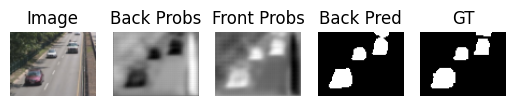

In [43]:
example_output = model(highwayDataset[10030][0]).detach()
example_probabilities = F.softmax(example_output, dim=0)
example_segmentation = example_probabilities.argmax(dim=0)

plt.figure()

plt.subplot(1, 5, 1)
plt.imshow(highwayDataset[10030][0].detach().cpu().permute(1, 2, 0))
plt.axis("off")
plt.title("Image")

plt.subplot(1, 5, 2)
plt.imshow(example_output[0].detach().cpu(), cmap="gray")
plt.axis("off")
plt.title("Back Probs")

plt.subplot(1, 5, 3)
#plt.imshow(torch.squeeze(model(d[10030][0]).detach(),0))
plt.imshow(example_output[1].detach().cpu(), cmap="gray")
plt.axis("off")
plt.title("Front Probs")

plt.subplot(1, 5, 4)
#plt.imshow(torch.squeeze(model(d[10030][0]).detach(),0))
plt.imshow(example_segmentation.detach().cpu(), cmap="gray")
plt.axis("off")
plt.title("Back Pred")

plt.subplot(1, 5, 5)
plt.imshow(highwayDataset[10030][1].detach().cpu(), cmap="gray")
plt.axis("off")
plt.title("GT")

plt.show()

# Training and Test Error over each Epoch
Later comment: TODO Looks very suspicious. Must be revisited. EDIT: Data split and loader setup seem correct. Did not find any leakage yet. Maybe investigate training vs val/test loss without training data augmentation? still suspicious..

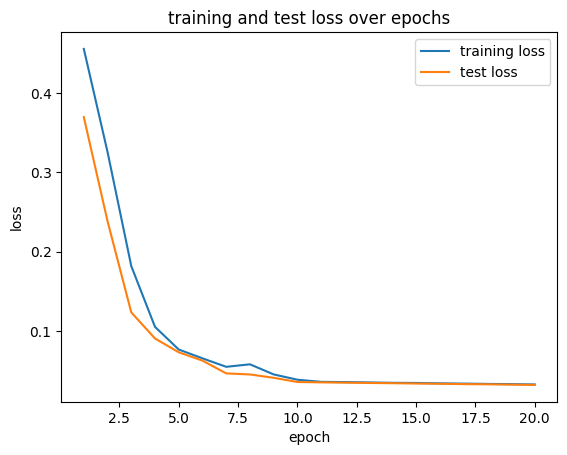

In [44]:
x = [ i+1 for i in range(epochs)]


plt.plot(x, train_losses, label='training loss')
plt.plot(x, test_losses, label='test loss')

plt.title('training and test loss over epochs')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()

plt.show()

## Evaluation Metrics for Final Model

In [45]:
print(highwayDataset.gts[test_dataset.indices].shape)
print(classification_report(highwayDataset.gts[test_dataset.indices].detach().cpu().flatten(), results.flatten()))

torch.Size([2460, 60, 80])
              precision    recall  f1-score   support

           0       0.99      0.99      0.99  10453859
           1       0.95      0.94      0.94   1354141

    accuracy                           0.99  11808000
   macro avg       0.97      0.97      0.97  11808000
weighted avg       0.99      0.99      0.99  11808000



[0.98       0.991875   0.98895833 ... 0.97354167 0.98       0.99166667]


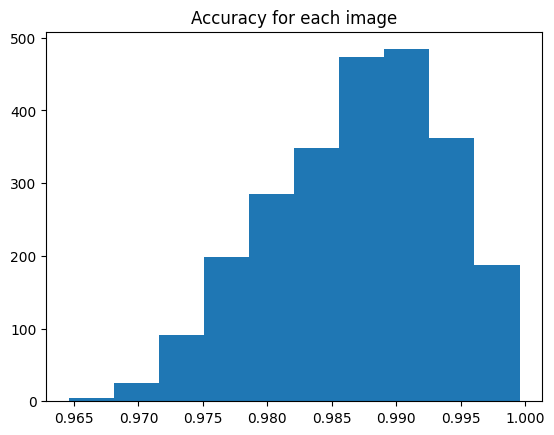

In [46]:
print(acc)
plt.hist(acc)
plt.title("Accuracy for each image")
plt.show()

[0.96449859 0.97748571 0.97600507 ... 0.97018967 0.96680512 0.96934271]


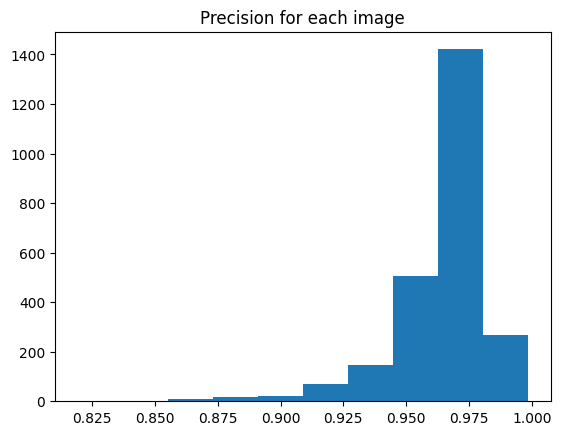

In [47]:
print(prec)
plt.hist(prec)
plt.title("Precision for each image")
plt.show()

[0.93210823 0.97247352 0.96525304 ... 0.95962117 0.96420186 0.96934271]


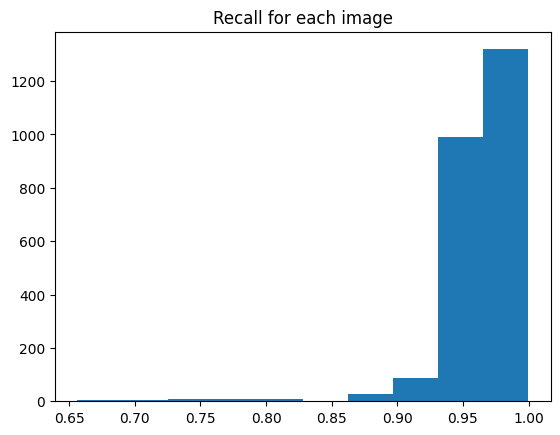

In [48]:
print(rec)
plt.hist(rec)
plt.title("Recall for each image")
plt.show()

[0.9032156  0.95193595 0.9437769  ... 0.93246212 0.93420033 0.94176028]


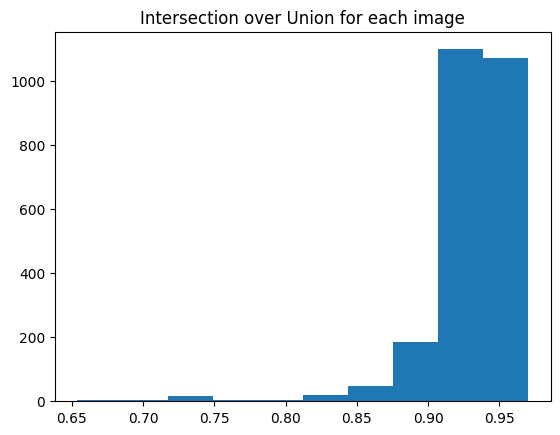

In [49]:
print(iou)
plt.hist(iou)
plt.title("Intersection over Union for each image")
plt.show()